In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import openai
import os

# Clustering
#import sklearn
import hdbscan
from sklearn.cluster import KMeans
# Dim reduction
from sklearn.manifold import TSNE
# Summarization


# src
from src.embed import get_embeddings

In [2]:
filepath = "C:\\Users\\hlmq\\OneDrive - Chevron\\Desktop\\Projects\\Tech Abstracts\\data\\"
filename = "2023 Tech Showcase Abstracts - with flags.csv"

df = pd.read_csv(str(filepath)+str(filename))

In [3]:
## VARIABLES

TEXT_FIELD = "Abstract Text (limit to 250 words)"

In [4]:
df.head()

,Selected,year,Abstract Title,Abstract Text (limit to 250 words)
0,Yes,2023,Scaling Aircraft-Based Methane Detection acros...,Methane emission reductions from the oil and g...
1,NaN,2023,Development and Deployment of Chevron's Fractu...,Embedded Discrete Fracture Modeling (EDFM) is ...
2,yes,2023,Hydrogen Must Win Technology Challenge linkage...,Chevron aims to leverage our strengths to deli...
3,Yes,2023,Leveraging the Digital Oilfield: Optimizing Op...,"The Tech Center, in collaboration with PE and ..."
4,NaN,2023,Leveraging Technology to Improve Hydraulic Fra...,"Development and deployment of fit-for-purpose,..."


## Embed Text

In [5]:
# Generate embeddings
abstracts = df[TEXT_FIELD].to_list()
embeddings = get_embeddings(abstracts)

## Cluster Text

In [6]:
# HDBScan
hdb = hdbscan.HDBSCAN(
    min_samples=1, 
    min_cluster_size=5,
    allow_single_cluster=False,
    cluster_selection_epsilon=0.3
    #store_centers="medoid"
    ).fit(embeddings)

In [7]:
cluster = KMeans(n_clusters=10).fit(embeddings)

In [8]:
#df['Cluster Label'] = hdb.labels_
#df['Cluster Probability'] = hdb.probabilities_

df['Cluster Label'] = cluster.labels_
#df['Cluster Probability'] = cluster.probabilities_

#print(len(hdb.medoids_))

df['Cluster Label'].value_counts()

5    21
0    20
2    15
4    14
8    12
1    10
7     7
3     6
6     3
9     2
Name: Cluster Label, dtype: int64

In [26]:
## Testing purposes for summary notebook.  REMOVE

check = df[df['Cluster Label']==2]
check.reset_index(inplace=True)
check = check['index'].tolist()
print(check)

[0, 2, 7, 16, 36, 37, 38, 46, 53, 55, 61, 79, 102, 104, 108]


In [ ]:
#sns.displot(df['Cluster Probability'])

## Reduce Embedding Dimensions

In [10]:
tsne = TSNE(
    n_components=2,
    perplexity=10,
    n_iter=5000,
    init = "pca",
    random_state = 0
)
reduced_embeddings = tsne.fit_transform(embeddings)

c:\ProgramData\Miniconda3\envs\nlp_cluster\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
c:\ProgramData\Miniconda3\envs\nlp_cluster\lib\site-packages\sklearn\manifold\_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


## Summarize Clusters

In [11]:
def select_obs_in_cluster(data, cluster_label, n_samples=3):
    """ 
    Returns n observations from each cluster.  Keep all observations if less than n_samples. 
    
    Inputs
    data - df - dataframe of observations
    cluster_label - int - unique cluster label to filter on
    n_samples - int - number of observations keep from a cluster

    Outputs
    observation - str - n_samples observations joined together from each cluster.
    """

    # Filter on the cluster label
    temp_df = data[data['Cluster Label']==cluster_label]

    # Check how many observations in the df. If too many, shorten it.
    if len(temp_df) >= n_samples:
        # Create a df with less observations.  Don't have probability with kmeans so just slicing.
        temp_df = temp_df.iloc[:n_samples]
        observation = ', '.join(temp_df['Abstract Text (limit to 250 words)'].tolist())
    else:
        # Keep all obs if less than n_samples
        temp_df = data

    return observation


def create_summary(observation=None, prompt_style=None):

    openai.api_type = "azure"
    openai.api_base = "https://crrc-t170-cvx-france.openai.azure.com/"
    openai.api_version = "2023-09-15-preview"
    openai.api_key = os.getenv("OPENAI_API_KEY")
    openai.api_key = "8a4a2a3d7af2430188ee31adcc298c45"

    if prompt_style == "description":
        prompt_text = f"Context: {observation}. Capture the main idea of these projects in a MAXIMUM of 6 words. `DO NOT PROVIDE ANY ADDITIONAL EXPLANATION OR DETAILS`. example\n\n Subsea Structure Characterization"
    elif prompt_style == "question":
        prompt_text = f"Context: {observation}. Create a short, unique question to ask about the following projects. `DO NOT PROVIDE ANY ADDITIONAL EXPLANATION OR DETAILS`. example\n\n Subsea Structure Characterization"
    else:
        return f"No prompt specified!"


    response = openai.Completion.create(
        engine="gpt-35-turbo",
        prompt=prompt_text,
        temperature=0,
        max_tokens=9,
        top_p=1,
        frequency_penalty=1,
        presence_penalty=0,
        stop=None)

    return response['choices'][0]['text']

In [14]:
df.head()

,Selected,year,Abstract Title,Abstract Text (limit to 250 words),Cluster Label
0,Yes,2023,Scaling Aircraft-Based Methane Detection acros...,Methane emission reductions from the oil and g...,2
1,NaN,2023,Development and Deployment of Chevron's Fractu...,Embedded Discrete Fracture Modeling (EDFM) is ...,5
2,yes,2023,Hydrogen Must Win Technology Challenge linkage...,Chevron aims to leverage our strengths to deli...,2
3,Yes,2023,Leveraging the Digital Oilfield: Optimizing Op...,"The Tech Center, in collaboration with PE and ...",4
4,NaN,2023,Leveraging Technology to Improve Hydraulic Fra...,"Development and deployment of fit-for-purpose,...",1


In [16]:

# Create dataframe to house the results
results = pd.DataFrame()
results['Cluster Label'] = df['Cluster Label'].unique()
# Sort and Reindex the df
results.sort_values(by='Cluster Label', inplace=True, ignore_index=True)

,Cluster Label
0,0
1,1
2,2
3,3
4,4
5,5
6,6
7,7
8,8
9,9


In [12]:
### NOT WORKING YET
for i in results['Cluster Label'].unique():
    # Initialize cluster label value
    cluster_label=i
    # Only keep top n observations
    observation = select_obs_in_cluster(data=df, cluster_label=cluster_label, n_samples=4)
    # 
    results['Cluster Description'] = create_summary(observation=observation, prompt_style="description")
    results['Cluster Question'] = create_summary(observation=observation, prompt_style="question")
    


UnboundLocalError: local variable 'observation' referenced before assignment

## Visualize Plot

c:\ProgramData\Miniconda3\envs\nlp_cluster\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


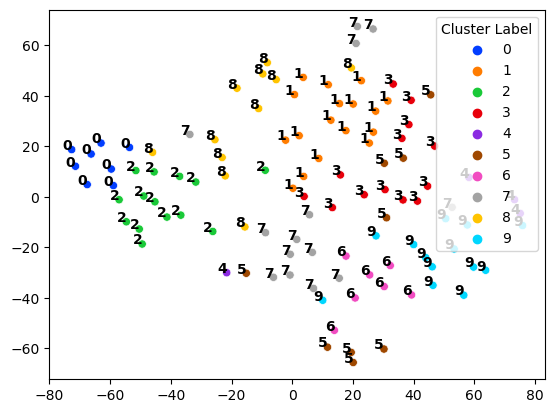

In [10]:
p1 = sns.scatterplot(reduced_embeddings[:,0], reduced_embeddings[:,1], hue=df['Cluster Label'], legend='full', palette="bright")

for line in range(0,df.shape[0]):
     p1.text(reduced_embeddings[:,0][line]+0.01, reduced_embeddings[:,1][line], 
     df['Cluster Label'][line],
     horizontalalignment='right',
     size='medium', 
     color='black', 
     weight='semibold')

## Appendix

In [ ]:
# Filter df to the largest values in a column
#temp_df = temp_df.nlargest(3, columns='Cluster Probability', keep='first')